***
#### Importing necessary libraries

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from matplotlib import pyplot as plt

> Note: You must run this cell before running any other cells in this notebook.
***

# IBM Quantum Demo
***
In this notebook I will go through the process of using the IBM Quantum Platform using Qiskit. 

> Note: This guide was created July 2024 and it is possible the IBM Quantum Platform API specification has changed since then.

## Obtaining an API Token
It is possible for anyone to obtain an API token to for the IBM Quantum Platform. Follow the steps below to do so:
1. Go to [IBM Quantum](https://www.ibm.com/quantum) and click *Sign in to Platform* in the top right.
2. Under the prompt *New to IBM Quantum?* click the link *Create an IBMid*.
3. Follow the steps to create an IBMid.
4. Once you have obtained an IBMid you will be able to sign into IBM Quantum Platform.
5. Your API token can be found on the top right of your dashboard.

## Adding Your API Token
To use the IBM Quantum Platform API you must first get your API token and added it to the project. For security I have excluded my API token from the contents of this Git repository but will walk you though adding yours here.
1. On the dashboard of the IBM Quantum Platform you will find your API token in the top right.
2. In the directory of this notebook create a text file named *API_KEYS.txt*.
3. Copy the token and paste it in the [API_KEYS.txt](API_KEYS.txt) file with "IBM_QUANTUM =" preceding it.
4. The contents of this file should look like "IBM_QUANTUM = YOUR_TOKEN_HERE" with your token in place of "YOUR_TOKEN_HERE".
5. Save and close the file.  
6. Run the code cell below to add your API token to the project.

In [3]:
keys = open('API_KEYS.txt', 'r').read().splitlines()
for key in keys:
    if key.startswith('IBM_QUANTUM'):
        IBM_QUANTUM_API_KEY = key.split(' = ')[1]
        break

# Create a Qiskit Runtime service for the IBM Quantum provider
service = QiskitRuntimeService(channel = "ibm_quantum" , token = IBM_QUANTUM_API_KEY)

## Testing the API Token
The basic piece of code below will test if you have added your API Token correctly.

### Create a basic circuit

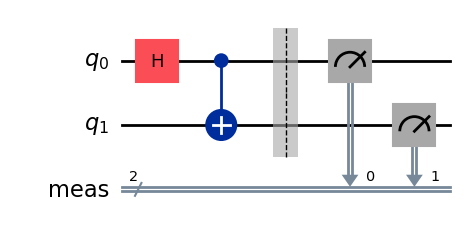

In [16]:
# Create a quantum circuit that prepares a Bell state.
base_qc = QuantumCircuit(2)
base_qc.h(0)
base_qc.cx(0, 1)

# Copy the circuit and add measurements to the circuit.
qc = base_qc.copy()
qc.measure_all()

# Draw the circuit.
qc.draw('mpl')

### Test the circuit with a fake backend

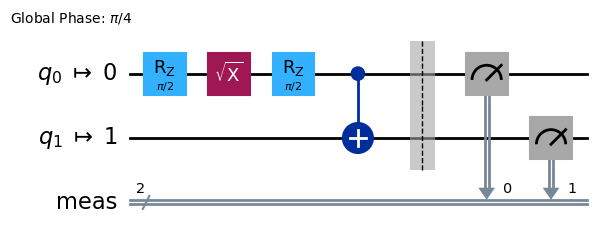

In [17]:
# Generate a 2 qubit simulated backend.
backend = GenericBackendV2(num_qubits = 2)

# Transpile the circuit for the backend.
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl')

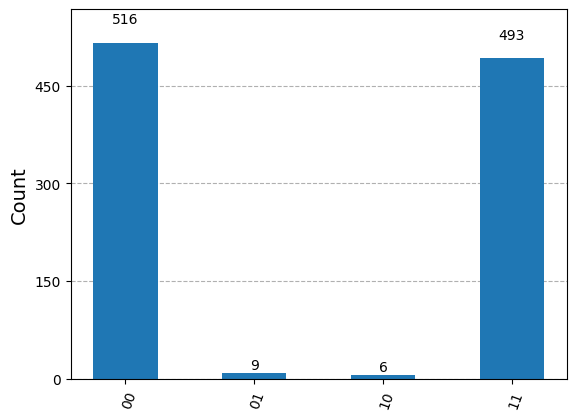

In [18]:
# Run the transpiled circuit using the simulated noisy backend.
job = backend.run(transpiled_qc)
counts = job.result().get_counts()
plot_histogram(counts)

### Run the circuit on an IBM Quantum Device

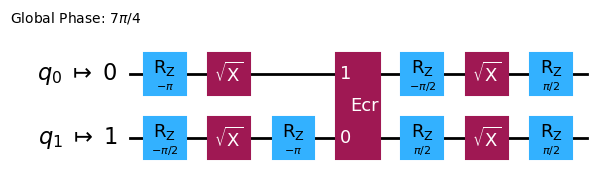

In [26]:
# Get the least busy backend for the Qiskit provider.
backend = service.least_busy(simulator = False, operational = True)

# Transpile the circuit using for the backend.
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl', idle_wires = False)

In [ ]:
# Run the circuit on the real IBM Quantum backend.
job = backend.run(transpiled_qc)

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

In [ ]:
counts = job.result().get_counts()
plot_histogram(counts)

We expect to equally measure the outcomes 00 and 11 for a Bell state. Due to simulated noise there are some occurrences of the 01 and 10 outcomes. If the measurement outcomes are roughly equal counts 00 and 11 we can be fairly confident the circuit is working as expected. Lets do another demo.

Remove the measurements and use the estimator to estimate some Pauli observables.

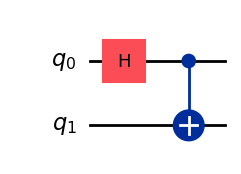

In [19]:
# Copy the base circuit from before we added measurements.
qc = base_qc.copy()

qc.draw('mpl')

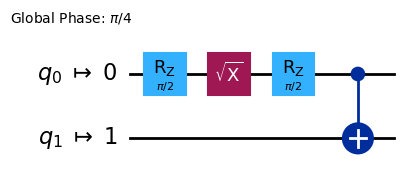

In [20]:
# Generate a 2 qubit simulated backend.
backend = GenericBackendV2(num_qubits = 2)

# Transpile the circuit using the backend.
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl')

In [21]:
# Set up six different observables.
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [22]:
# Run the transpiled estimating the expectation values of the observables.
estimator = Estimator(mode = backend) 
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [observable.apply_layout(transpiled_qc.layout) for observable in observables]

job = estimator.run([(transpiled_qc, mapped_observables)])

In [23]:
job_result = job.result()

pub_result = job.result()[0]

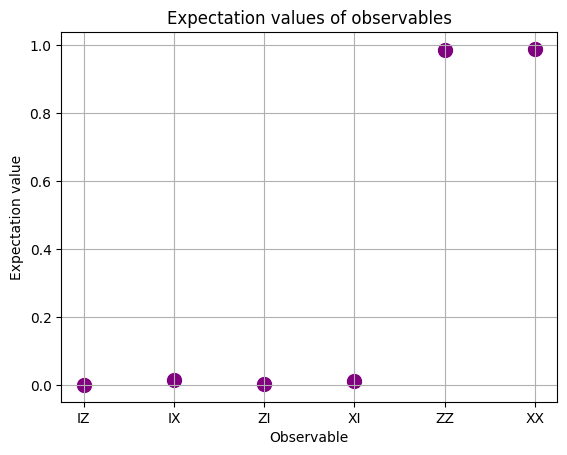

In [24]:
# Plot the results.

# Getting the data from the result.
values = pub_result.data.evs

errors = pub_result.data.stds

# Plotting the graph.
plt.scatter(observables_labels, values, color='purple', s = 100)
plt.ylabel('Expectation value')
plt.xlabel('Observable')
plt.title('Expectation values of observables')
plt.grid()
plt.show()


For a Bell State we expect the individual X and Z expectation values be 0 and the correlations, XX and ZZ, be 1. If these are the results that appear in the plots then we can be fairly confident the circuit is working as expect so we can run it on a IBM Quantum device.

### Run the circuit on an IBM Quantum Device

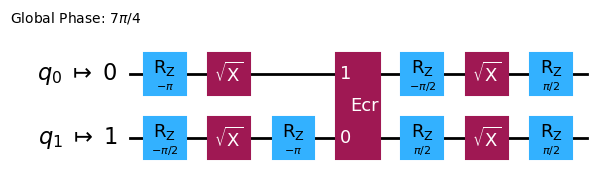

In [28]:
# Get the least busy backend for the Qiskit provider.
backend = service.least_busy(simulator = False, operational = True)

# Transpile the circuit using for the backend.
transpiled_qc = transpile(qc, backend)
transpiled_qc.draw('mpl', idle_wires = False)

In [29]:
# Run the transpiled estimating the expectation values of the observables.
estimator = Estimator(mode = backend) 
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [observable.apply_layout(transpiled_qc.layout) for observable in observables]

job = estimator.run([(transpiled_qc, mapped_observables)])

In [ ]:
job_result = job.result()

pub_result = job.result()[0]

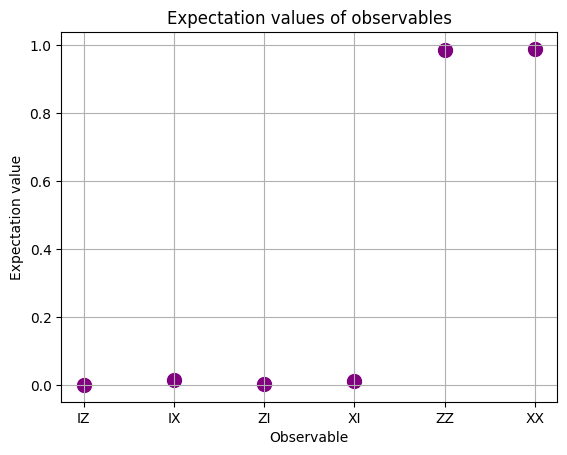

In [ ]:
# Plot the results.

# Getting the data from the result.
values = pub_result.data.evs

errors = pub_result.data.stds

# Plotting the graph.
plt.scatter(observables_labels, values, color='purple', s = 100)
plt.ylabel('Expectation value')
plt.xlabel('Observable')
plt.title('Expectation values of observables')
plt.grid()
plt.show()
